In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product d.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_d= df.drop(['Product Name','Product Category','Month','Year', 'Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_d.shape

(60, 1)

In [5]:
sales_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_d['Sales'].sum()

7173488

Text(0.5, 1.0, 'Product D')

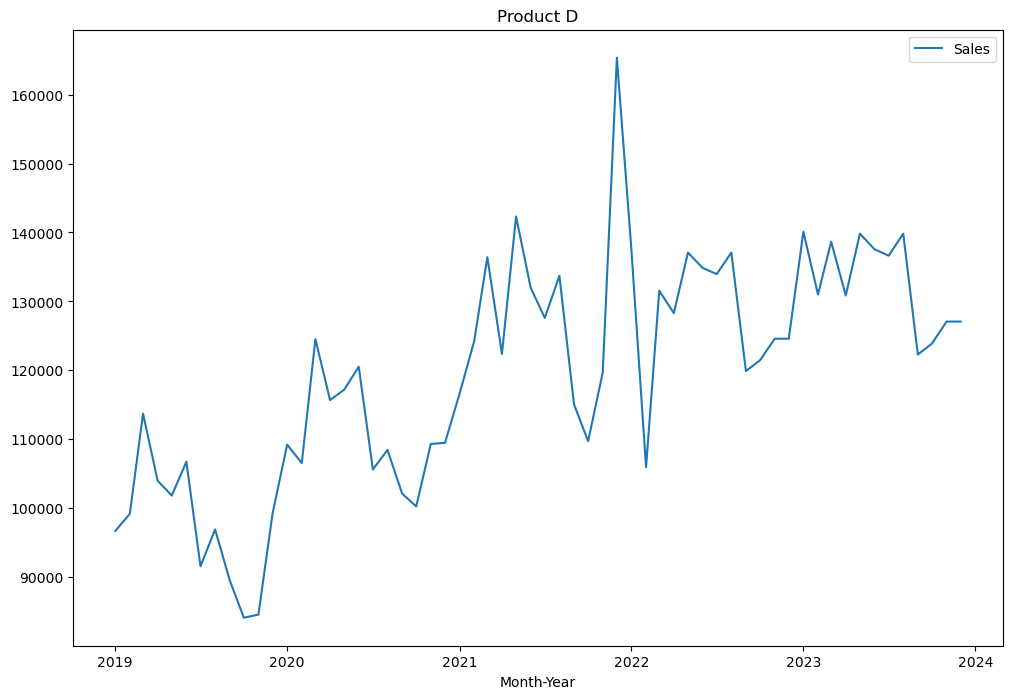

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_d)
plt.title('Product D')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_d)

ADF Statistics: -2.3249460487083105
p- value: 0.16404854202961083
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_d_diff= sales_d.diff().dropna()

Text(0.5, 1.0, 'Product D- First Difference')

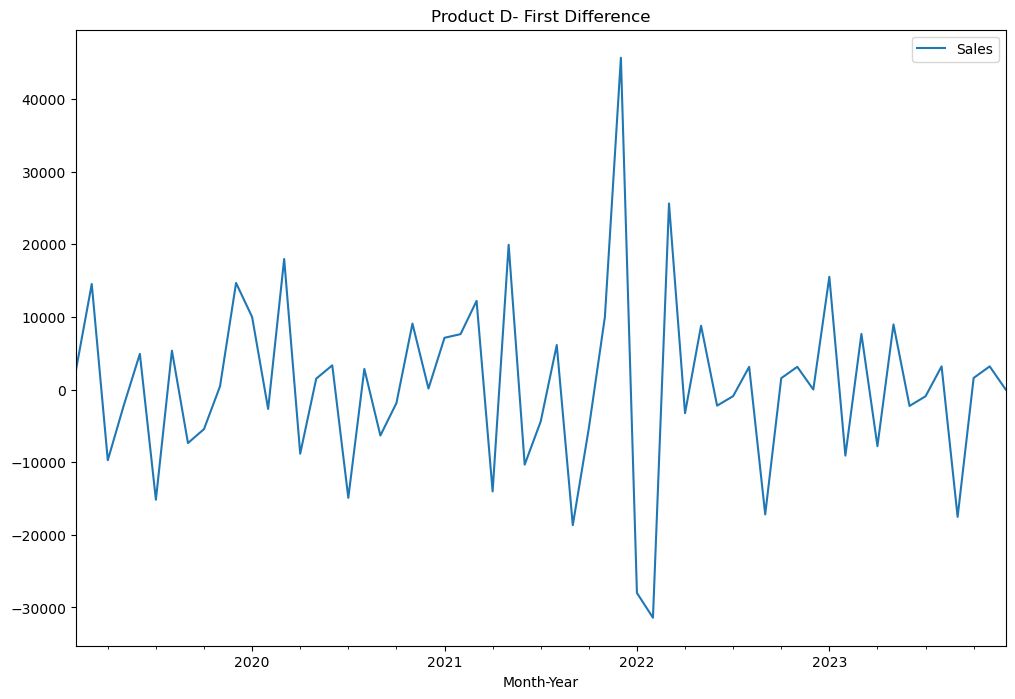

In [11]:
sales_d_diff.plot(figsize=(12,8))
plt.title('Product D- First Difference')

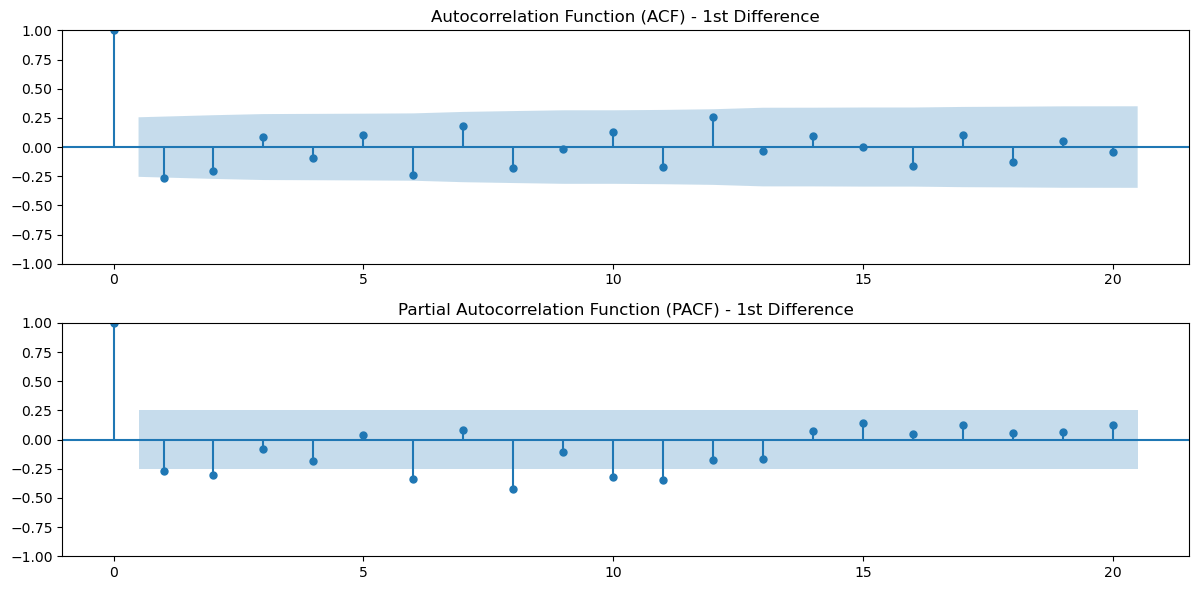

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_d_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_d_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_d_diff)

ADF Statistics: -4.6011480666771325
p- value: 0.00012854172822943823
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_d[:57]
test=sales_d[57:]

In [15]:
print(len(train), len(test))

57 3


In [16]:
# combination p=(1,2,3,4,5) d=1 q=(0,1) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(1,1,0), (1, 1, 1), (2,1,0), (2, 1, 1),(3,1,0), (3, 1, 1),(4,1,0), (4, 1, 1), (5,1,0), (5, 1, 1)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(2):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_d)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic          mae           mse         rmse
0   0  0  1219.289012  1221.314363  3718.666667  1.608559e+07  4010.683982
1   0  1  1219.597790  1223.648493  1889.601870  4.272006e+06  2066.883104
2   1  0  1219.693030  1223.743734  2114.810653  5.776578e+06  2403.451349
3   1  1  1220.544847  1226.620902   715.422393  6.301870e+05   793.843205
4   2  0  1221.909379  1227.985434  1641.875362  3.281438e+06  1811.473944
5   2  1  1222.627004  1230.728411   856.670819  8.283184e+05   910.120016
9   4  1  1223.254005  1235.406115  1595.639250  3.894294e+06  1973.396687
6   3  0  1223.672266  1231.773672  1367.866908  2.125113e+06  1457.776804
11  5  1  1224.423374  1238.600836  1651.623674  4.710079e+06  2170.271543
7   3  1  1224.502985  1234.629743   881.346091  1.012205e+06  1006.084092
8   4  0  1225.153040  1235.279798  1103.318820  1.271285e+06  1127.512887
10  5  0  1226.671789  1238.823900  1232.430057  1.533458e+06  1238.328892


In [20]:
m_arima= ARIMA (train, order=(0,1,0))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   57
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -608.645
Date:                Thu, 09 May 2024   AIC                           1219.289
Time:                        16:34:24   BIC                           1221.314
Sample:                    01-01-2019   HQIC                          1220.074
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.585e+08   2.07e+07      7.649      0.000    1.18e+08    1.99e+08
Ljung-Box (L1) (Q):                   4.19   Jarque-Bera (JB):                10.70
Prob(Q):                              0.04   Pr

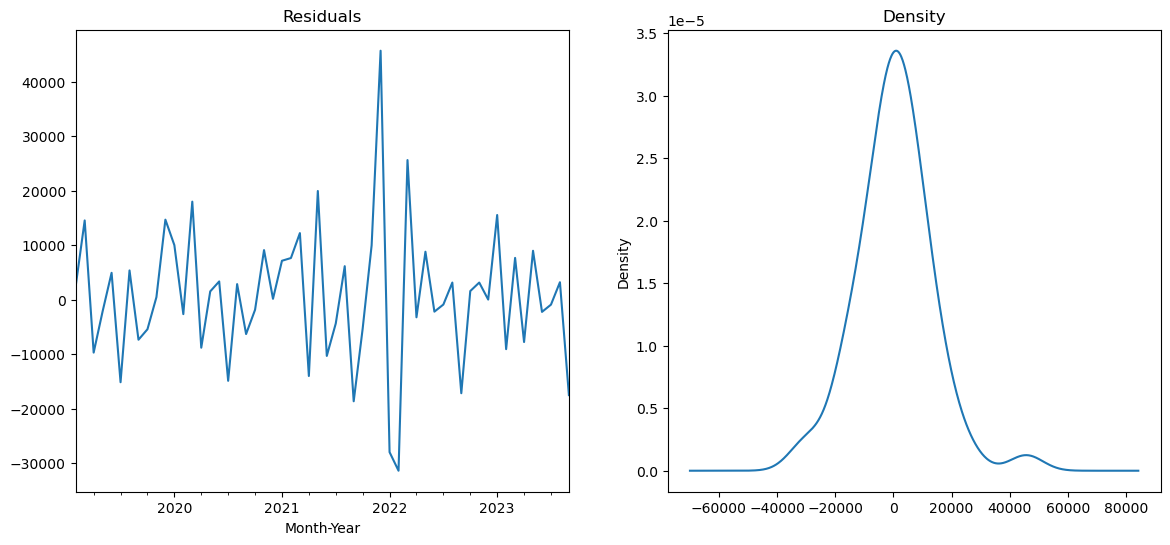

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

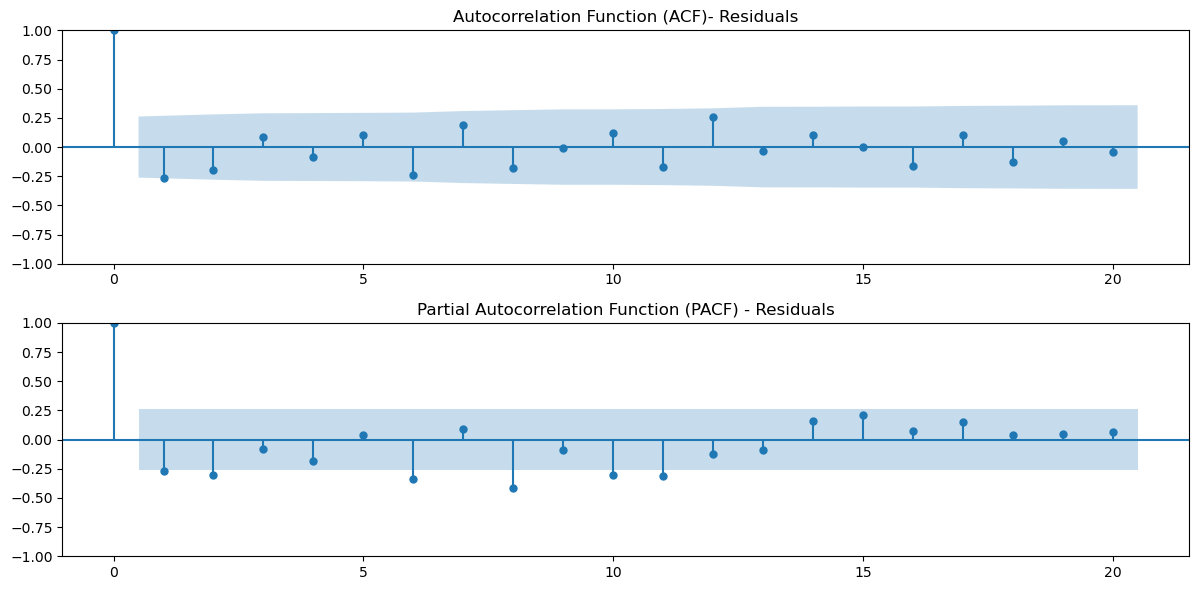

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

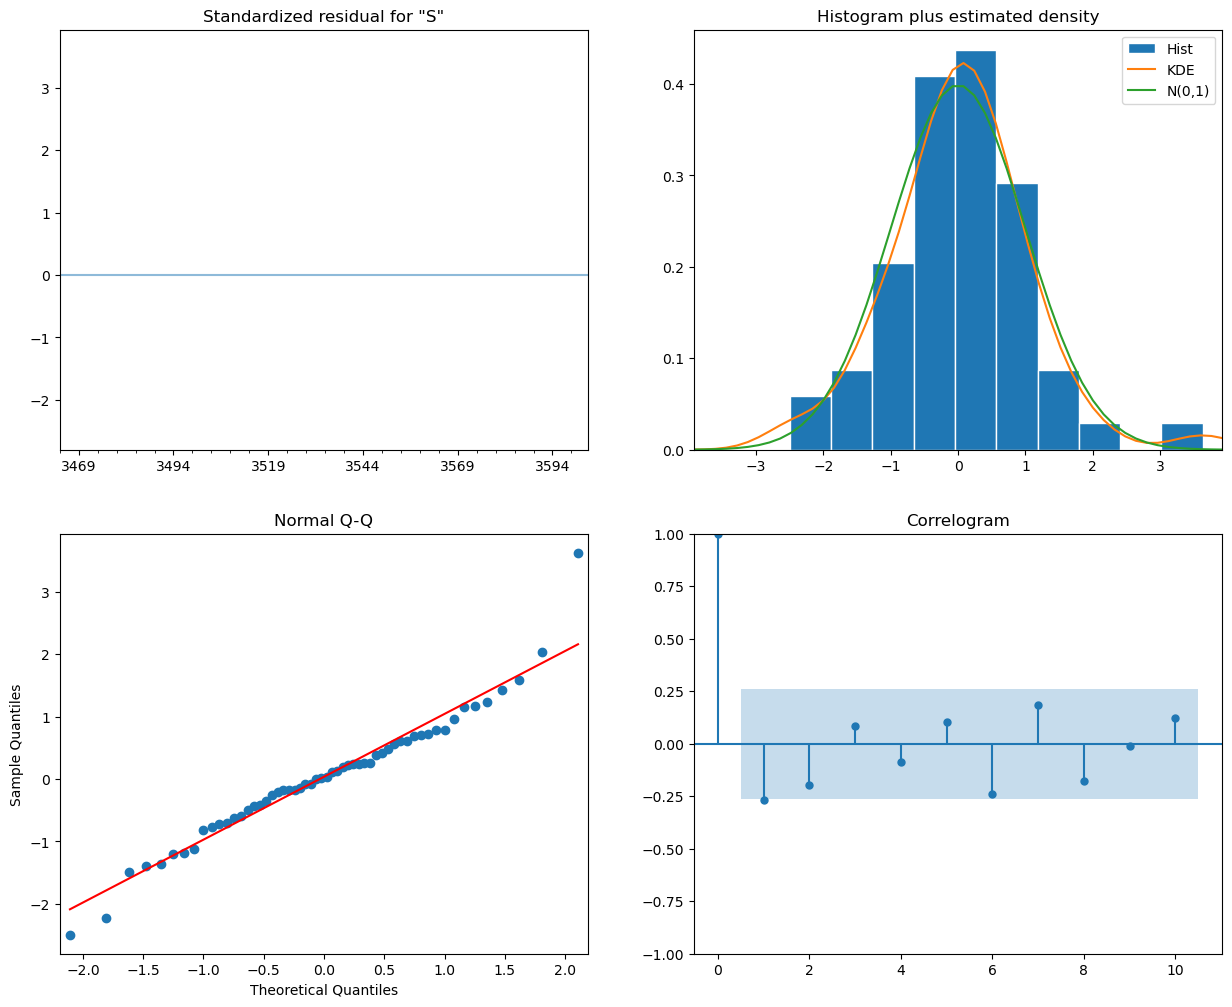

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_d['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_d.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_d)-1), dynamic = True)
sales_d['Forecast_ARIMA']=[None]*len(train) + list(pred)

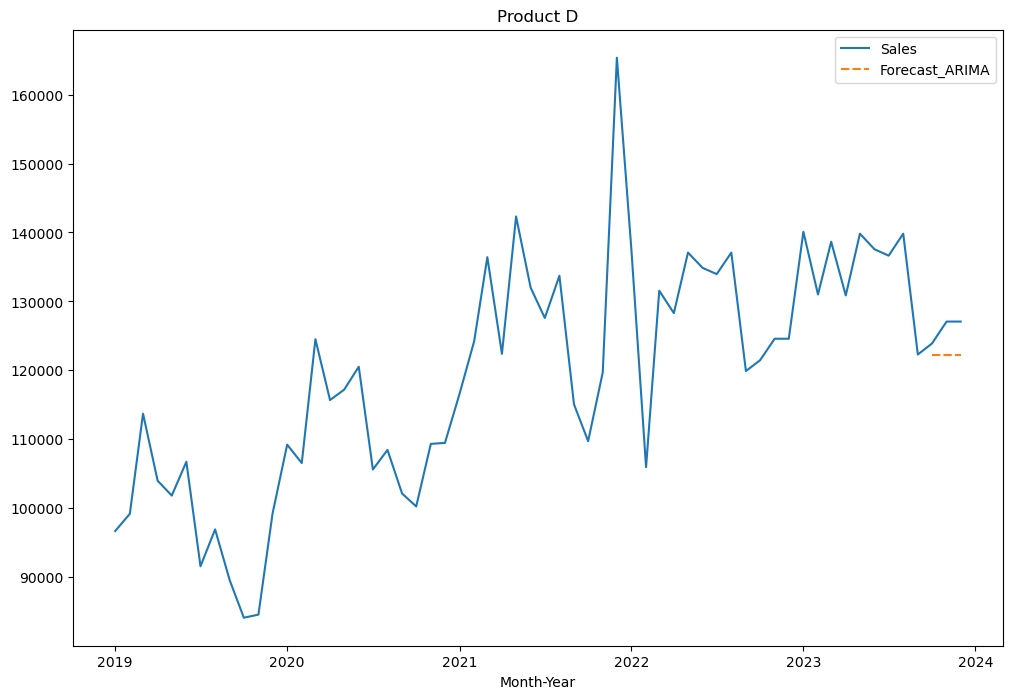

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_ARIMA']])
plt.title('Product D')
plt.show()

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 3718.6666666666665
MAPE - ARIMA: 0.02937135249041492
MSE - ARIMA: 16085586.0
RMSE - ARIMA: 4010.683981567234


# SARIMA

In [28]:
import statsmodels.api as sm

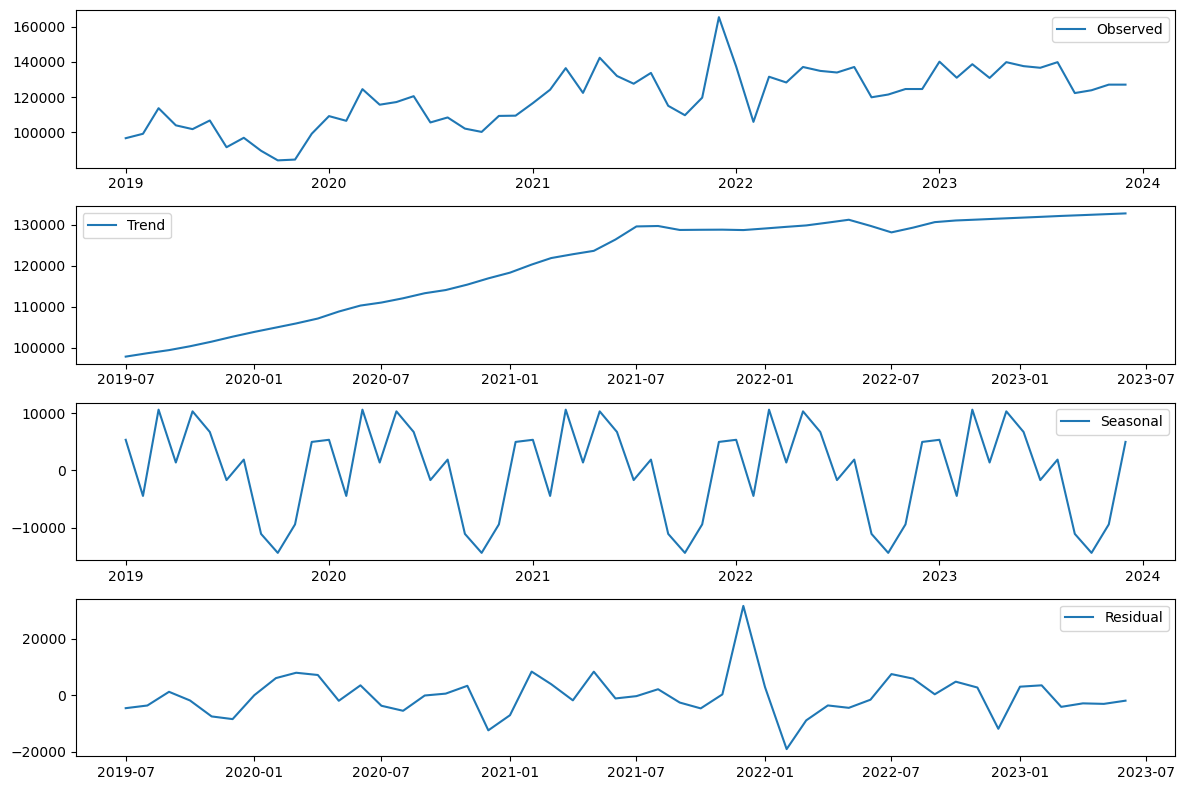

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_d['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

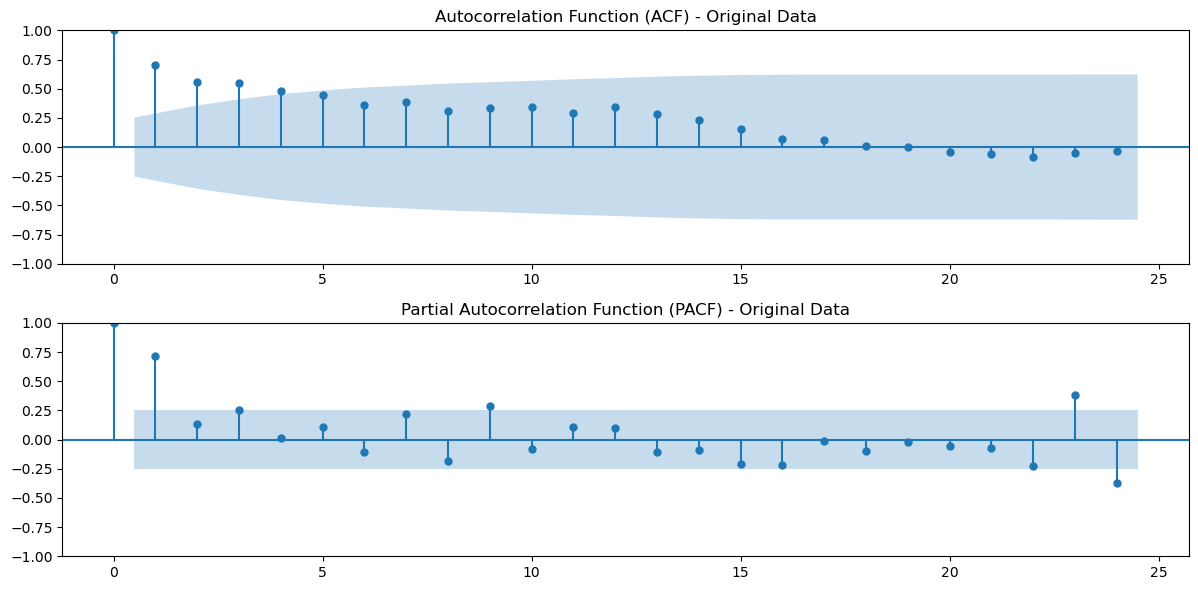

In [30]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_d['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_d['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [31]:
order_SARIMAX=[]
# Loop over P order
for P in range(5):
    # Loop over Q order
    for Q in range(4):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(0, 1, 0), seasonal_order=(P, 0, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=57, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [32]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q          aic          bic          mae           mse
16  4  0  1208.692881  1218.819640  5390.874845  3.204086e+07
6   1  2  1211.834225  1219.935632  4678.524982  2.392288e+07
3   0  3  1213.366966  1221.468372  3681.874022  1.541976e+07
7   1  3  1213.537156  1223.663915  4731.895506  2.449212e+07
10  2  2  1213.833276  1223.960035  4703.805796  2.419128e+07
2   0  2  1215.178540  1221.254595  3630.160299  1.513006e+07
11  2  3  1215.531205  1227.683315  4777.631792  2.495839e+07
12  3  0  1215.732107  1223.833514  5079.202231  3.226837e+07
14  3  2  1215.813133  1227.965243  4647.853201  2.366535e+07
8   2  0  1216.972295  1223.048350  3583.690894  1.408063e+07
15  3  3  1217.509969  1231.687431  4789.752964  2.502986e+07
18  4  2  1217.558306  1231.735767  4719.026206  2.424900e+07
4   1  0  1217.867333  1221.918036  3072.127522  1.097845e+07
5   1  1  1218.198376  1224.274431  1794.811134  5.282049e+06
19  4  3  1219.255620  1235.458434  4743.250206  2.450775e+07
0   0  0

In [33]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(0, 1, 0),seasonal_order=(4,0,0,12))
sarima_model=sarima.fit()

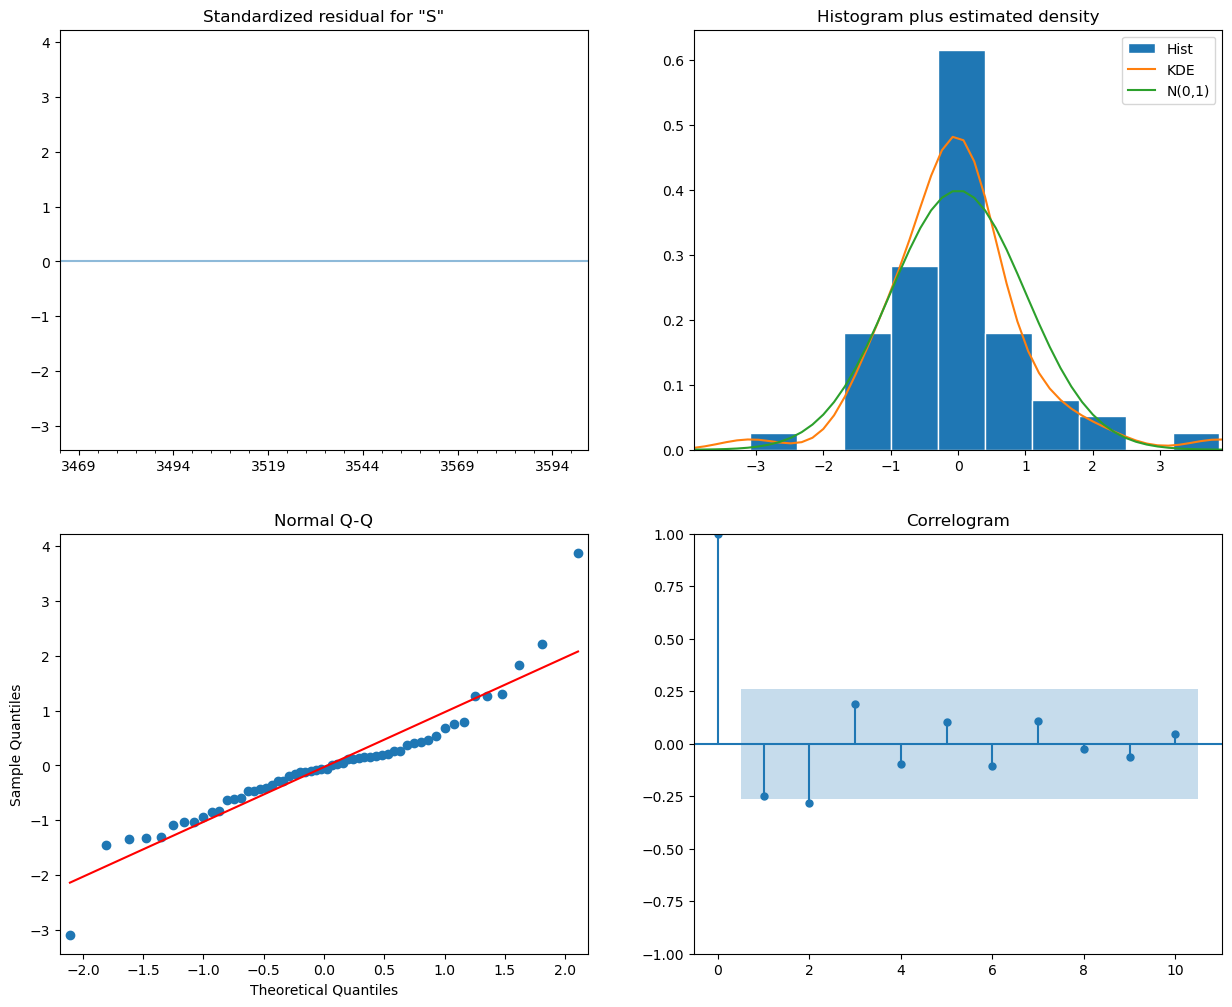

In [34]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [35]:
forecast_test_sarima=sarima_model.predict(start=57,end=59,dynamic=True)

In [36]:
sales_d['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product D')

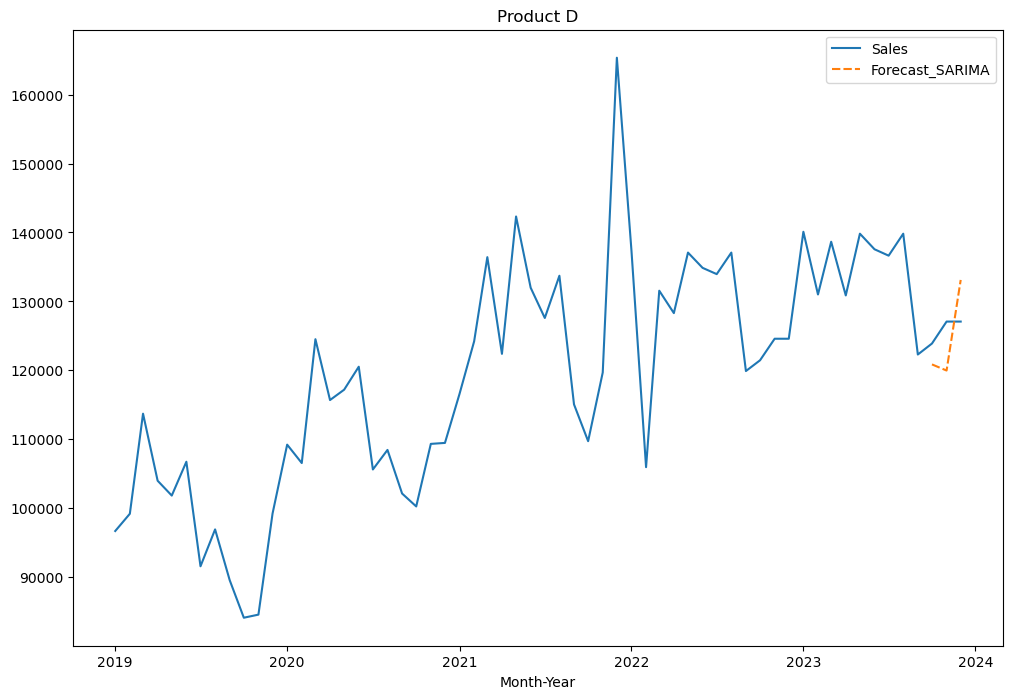

In [37]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_SARIMA']])
plt.title('Product D')

In [38]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 5390.875
MAPE - SARIMA: 0.043
MSE - SARIMA: 32040864.849
RMSE - SARIMA: 5660.465


# AUTO-ARIMA

In [39]:
import pmdarima as pm

In [40]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,max_q=3,
                          start_P=0, D=0, start_Q=0, max_P=5 ,max_Q=4 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1221.208, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1220.588, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1217.577, Time=0.20 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=1216.225, Time=0.72 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=1216.996, Time=2.73 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1219.715, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1220.763, Time=0.17 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1214.519, Time=0.46 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=1216.518, Time=1.18 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=1218.484, Time=7.10 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1218.880, Time=0.16 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1215.795, Time=0.34 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1216.519, Time=0.63 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=1218.471, Time=3.01 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=1217.196, Time=0.59

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True)

In [41]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   57
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -600.082
Date:                                 Thu, 09 May 2024   AIC                           1212.165
Time:                                         16:39:09   BIC                           1224.317
Sample:                                     01-01-2019   HQIC                          1216.876
                                          - 09-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    716.3197   4286.109      0.167      0.867   -7684.300    9116.939
ma.L1         -0.1981      0.091     -2.172      0.030      -0.377      -0.019
ar.S.L12      -0.7464      0.559     -1.336      0.182      -1.842       0.349
ma.S.L12       1.0432      0.619      1.684      0.092      -0.171       2.257
ma.S.L24       0.4889      0.225      2.170      0.030       0.047       0.931
sigma2      1.476e+08      0.010   1.51e+10      0.000    1.48e+08    1.48e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):                24.25
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.55
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.41e+26. Standard errors may be unstable.
"""

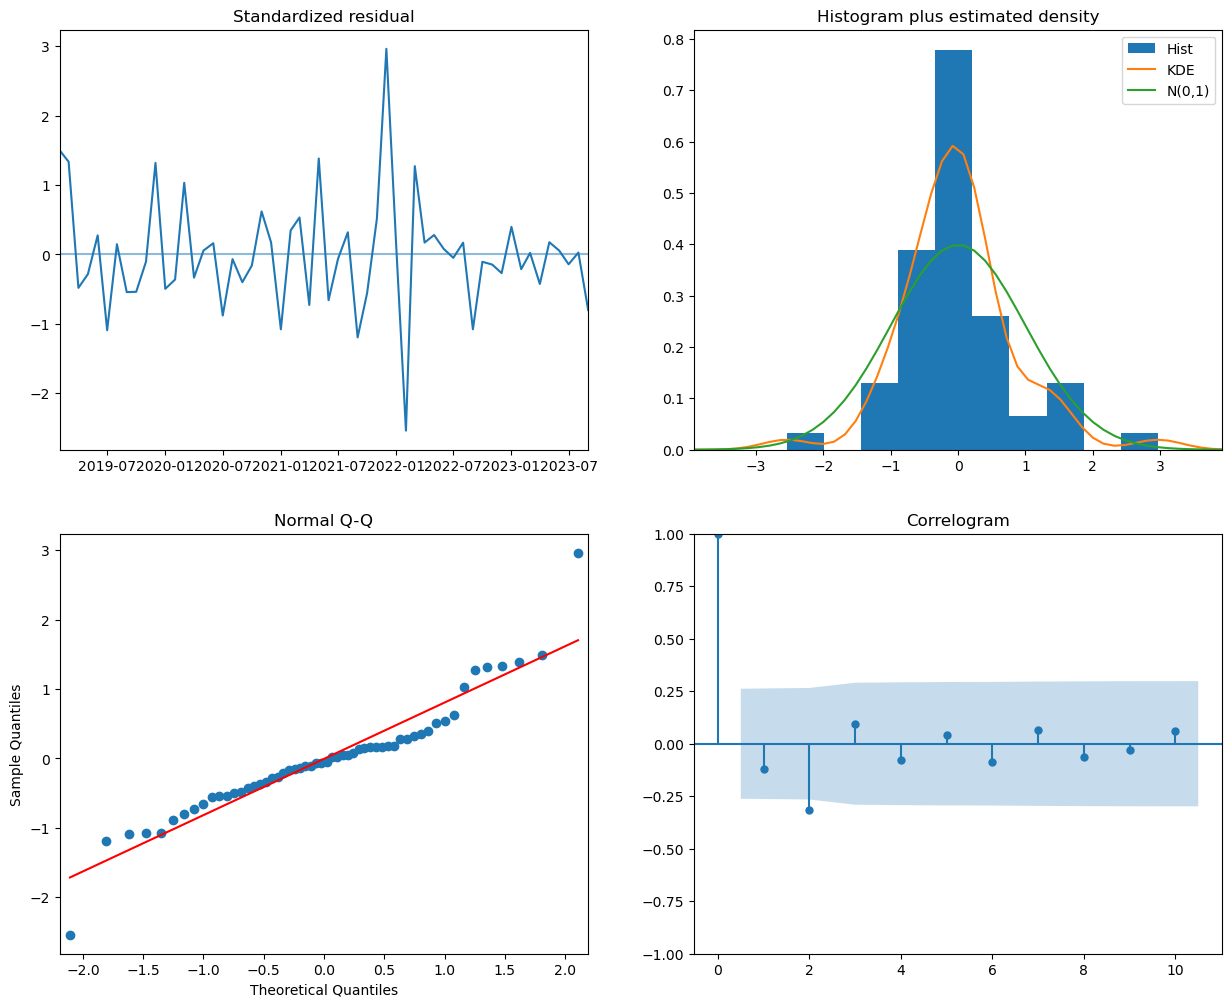

In [42]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [43]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_d['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_d[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product D')

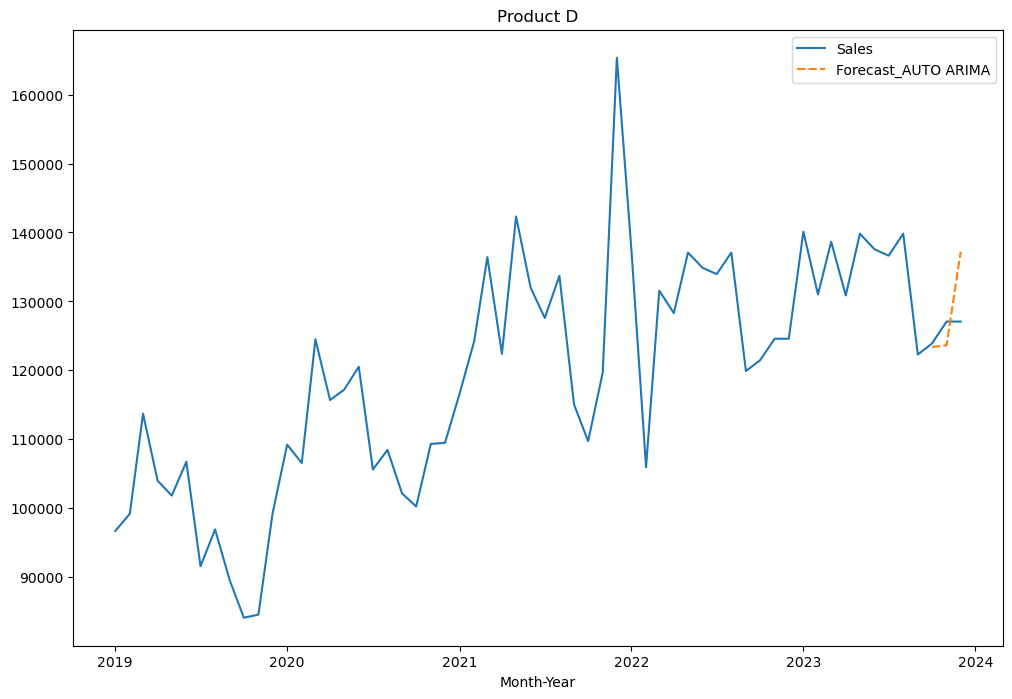

In [44]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product D')

In [45]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 4687.680335639496
MAPE - AUTO ARIMA: 0.03692365892824743
MSE - AUTO ARIMA: 38149631.24271319
RMSE - AUTO ARIMA: 6176.538775294233


In [46]:
sales_d.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,140104,NaN,NaN,NaN
2023-02-01,131006,NaN,NaN,NaN
2023-03-01,138656,NaN,NaN,NaN
2023-04-01,130866,NaN,NaN,NaN
2023-05-01,139824,NaN,NaN,NaN
2023-06-01,137565,NaN,NaN,NaN
2023-07-01,136637,NaN,NaN,NaN
2023-08-01,139824,NaN,NaN,NaN
2023-09-01,122293,NaN,NaN,NaN


In [47]:
sales_d.mean()

Sales                  119558.133333
Forecast_ARIMA         122293.000000
Forecast_SARIMA        124646.688629
Forecast_AUTO ARIMA    128069.522098
dtype: float64

In [48]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,3718.666667,0.029371,1.608559e+07,4010.683982
AUTO ARIMA,4687.680336,0.036924,3.814963e+07,6176.538775
SEASONAL ARIMA,5390.874845,0.042627,3.204086e+07,5660.465074


# TESTING

In [17]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1221.208, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1220.588, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1217.577, Time=0.24 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1219.715, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1220.763, Time=0.12 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1214.519, Time=0.44 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1218.880, Time=0.14 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1215.795, Time=0.26 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1216.519, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1221.340, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1220.752, Time=0.08 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1216.791, Time=0.22 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1219.881, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1221.160, Time=0.16 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1212.165, Time=0.46

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True)

In [18]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   57
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -600.082
Date:                                 Wed, 08 May 2024   AIC                           1212.165
Time:                                         18:59:46   BIC                           1224.317
Sample:                                     01-01-2019   HQIC                          1216.876
                                          - 09-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    716.3197   4286.109      0.167      0.867   -7684.300    9116.939
ma.L1         -0.1981      0.091     -2.172      0.030      -0.377      -0.019
ar.S.L12      -0.7464      0.559     -1.336      0.182      -1.842       0.349
ma.S.L12       1.0432      0.619      1.684      0.092      -0.171       2.257
ma.S.L24       0.4889      0.225      2.170      0.030       0.047       0.931
sigma2      1.476e+08      0.010   1.51e+10      0.000    1.48e+08    1.48e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):                24.25
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.55
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.41e+26. Standard errors may be unstable.
"""

In [19]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_d['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product D')

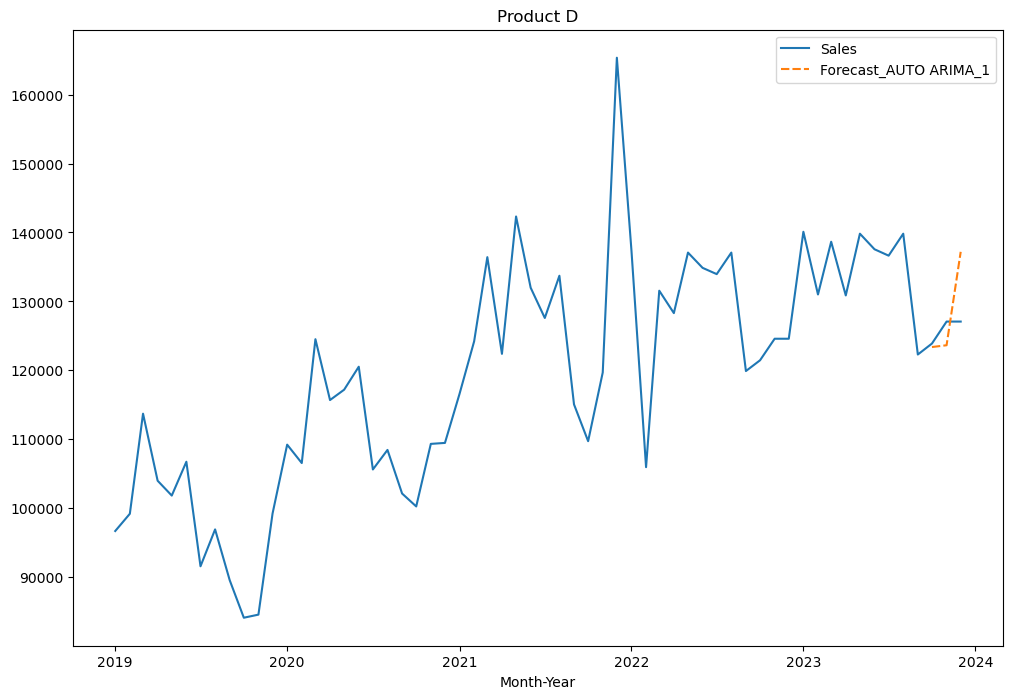

In [20]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product D')

In [21]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 4687.680335639496
MAPE - AUTO ARIMA: 0.03692365892824743
MSE - AUTO ARIMA: 38149631.24271319
RMSE - AUTO ARIMA: 6176.538775294233
